In [1]:
!pip install ucimlrepo

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import GridSearchCV
import os

# 1- Preparación de los Datos:


In [3]:
from ucimlrepo import fetch_ucirepo

air_quality = fetch_ucirepo(id=360)
Xair = air_quality.data.features
yair = air_quality.data.targets

In [4]:
# Crear el DataFrame con todas las características
df_total= air_quality.data.features

#Seleccionar las columnas específicas con las que se va a trabajar
df = df_total[['Date', 'Time', 'RH']]


In [5]:
print (df.head())

        Date      Time    RH
0  3/10/2004  18:00:00  48.9
1  3/10/2004  19:00:00  47.7
2  3/10/2004  20:00:00  54.0
3  3/10/2004  21:00:00  60.0
4  3/10/2004  22:00:00  59.6


In [6]:
# Crear columna Datetime combinada
df['Datetime'] = df['Date'] + ' ' + df['Time']

# Intentar convertir a datetime y capturar el error
# En lugar de poner format='%d/%m/%Y %H:%M:%S' poner dayfirst=False para que infiera automaticamente el formato
try:
    df['Datetime'] = pd.to_datetime(df['Datetime'], dayfirst=False)
except ValueError as e:
    print(f"Error al convertir fechas: {e}")

# Mostrars las filas que no se convirtieron correctamente
print(df[pd.to_datetime(df['Datetime'], errors='coerce').isnull()])

# Mostrar las filas que no se convirtieron correctamente para asegurarnos que se convirtió buen
invalid_dates = df[pd.to_datetime(df['Datetime'], errors='coerce').isnull()]
print("Filas con fechas no válidas:")
print(invalid_dates)

<ipython-input-6-49f10f11a4c9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Datetime'] = df['Date'] + ' ' + df['Time']
<ipython-input-6-49f10f11a4c9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Datetime'] = pd.to_datetime(df['Datetime'], dayfirst=False)


Empty DataFrame
Columns: [Date, Time, RH, Datetime]
Index: []
Filas con fechas no válidas:
Empty DataFrame
Columns: [Date, Time, RH, Datetime]
Index: []


In [7]:
# Establecer la columna datetime como índice, eliminar las columnas Date y Time
df.set_index('Datetime', inplace=True)
df.drop(['Date', 'Time'], axis=1, inplace=True)

<ipython-input-7-1b3827867698>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Date', 'Time'], axis=1, inplace=True)


In [8]:
# Reemplazar los valores -200 en la columna T con NaN

df['RH'] = df['RH'].replace(-200, pd.NA)


# Aplicar forward fill para reemplazar los valores NaN


df['RH'].ffill(inplace=True)

<ipython-input-8-e24550776077>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RH'] = df['RH'].replace(-200, pd.NA)
<ipython-input-8-e24550776077>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RH'].ffill(inplace=True)


# 2- Creación de lags y feature para SVR

In [9]:
# Definir número de lags y periodo estacional
lags = 24  # Lags para capturar información pasada
seasonal_period = 24  # Estacionalidad diaria

In [10]:
#Definimos la función pata crear las columnas de lags y características estacionales

def create_lagged_features(data, lags, seasonal_period):
    df = pd.DataFrame(data)
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df['RH'].shift(lag)
    for period in range(1, seasonal_period + 1):
        df[f'seasonal_lag_{period}'] = df['RH'].shift(period)
    df['target'] = df['RH']
    df.dropna(inplace=True)
    return df

In [11]:
#Crea el data frame con lagged y caracteristicas estacionales
df_lagged = create_lagged_features(df, lags, seasonal_period)
df_lagged.head()

,RH,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,seasonal_lag_16,seasonal_lag_17,seasonal_lag_18,seasonal_lag_19,seasonal_lag_20,seasonal_lag_21,seasonal_lag_22,seasonal_lag_23,seasonal_lag_24,target
Datetime,,,,,,,,,,,,,,,,,,,,,
2004-03-11 18:00:00,64.2,67.6,71.2,79.8,81.1,76.4,66.8,57.9,58.4,60.6,...,59.7,60.0,56.8,59.2,59.6,60.0,54.0,47.7,48.9,64.2
2004-03-11 19:00:00,69.3,64.2,67.6,71.2,79.8,81.1,76.4,66.8,57.9,58.4,...,60.2,59.7,60.0,56.8,59.2,59.6,60.0,54.0,47.7,69.3
2004-03-11 20:00:00,67.8,69.3,64.2,67.6,71.2,79.8,81.1,76.4,66.8,57.9,...,60.5,60.2,59.7,60.0,56.8,59.2,59.6,60.0,54.0,67.8
2004-03-11 21:00:00,64.0,67.8,69.3,64.2,67.6,71.2,79.8,81.1,76.4,66.8,...,56.2,60.5,60.2,59.7,60.0,56.8,59.2,59.6,60.0,64.0
2004-03-11 22:00:00,63.4,64.0,67.8,69.3,64.2,67.6,71.2,79.8,81.1,76.4,...,58.1,56.2,60.5,60.2,59.7,60.0,56.8,59.2,59.6,63.4


In [12]:
#Separa los valores en X e Y
X = df_lagged.drop(columns=['target']).values
y = df_lagged['target'].values

In [13]:
#Separación train (80%) y test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [14]:
#Se escalan los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3- Entrenamiento del Modelo SVM:

*Modelo con Kernel Radial*


In [ ]:
#Definición del modelo y entrenamiento
model1 = SVR(kernel='rbf', C=1000, gamma=0.1)
model1.fit(X_train_scaled, y_train)

SVR(C=1000, gamma=0.1)

In [ ]:
#Probamos otro valor de kernel
y_pred = model1.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print('MAE:', mae)
print('MSE:', mse)

MAE: 1.4724393571923282
MSE: 7.480567575322083


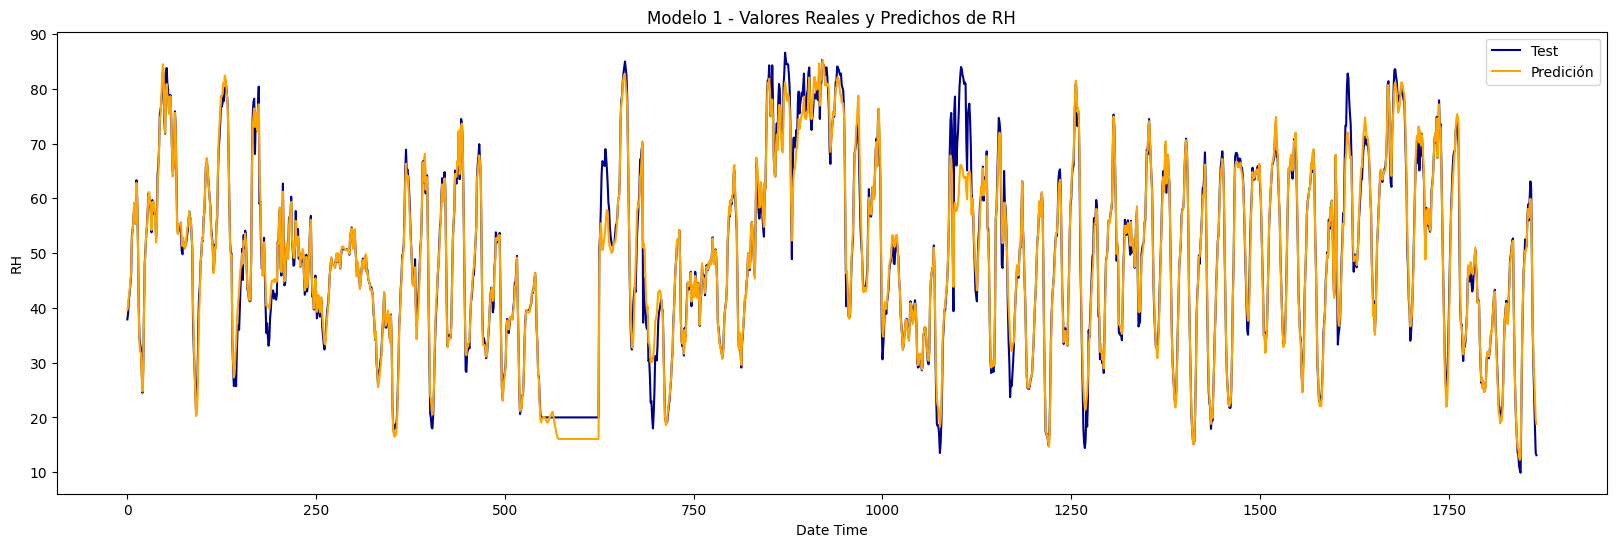

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(y_test, label='Test', color='darkblue')
plt.plot(y_pred, label='Predición', color='orange')
plt.xlabel('Date Time')
plt.ylabel('RH')
plt.title('Modelo 1 - Valores Reales y Predichos de RH')
plt.legend()
plt.show()

In [15]:
#Probamos otro valor de C

model2 = SVR(kernel='rbf', C=100, gamma=0.1)
model2.fit(X_train_scaled, y_train)

SVR(C=100, gamma=0.1)

In [ ]:
y_pred = model2.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print('MAE:', mae)
print('MSE:', mse)

MAE: 1.4710225734623452
MSE: 7.479578121933215


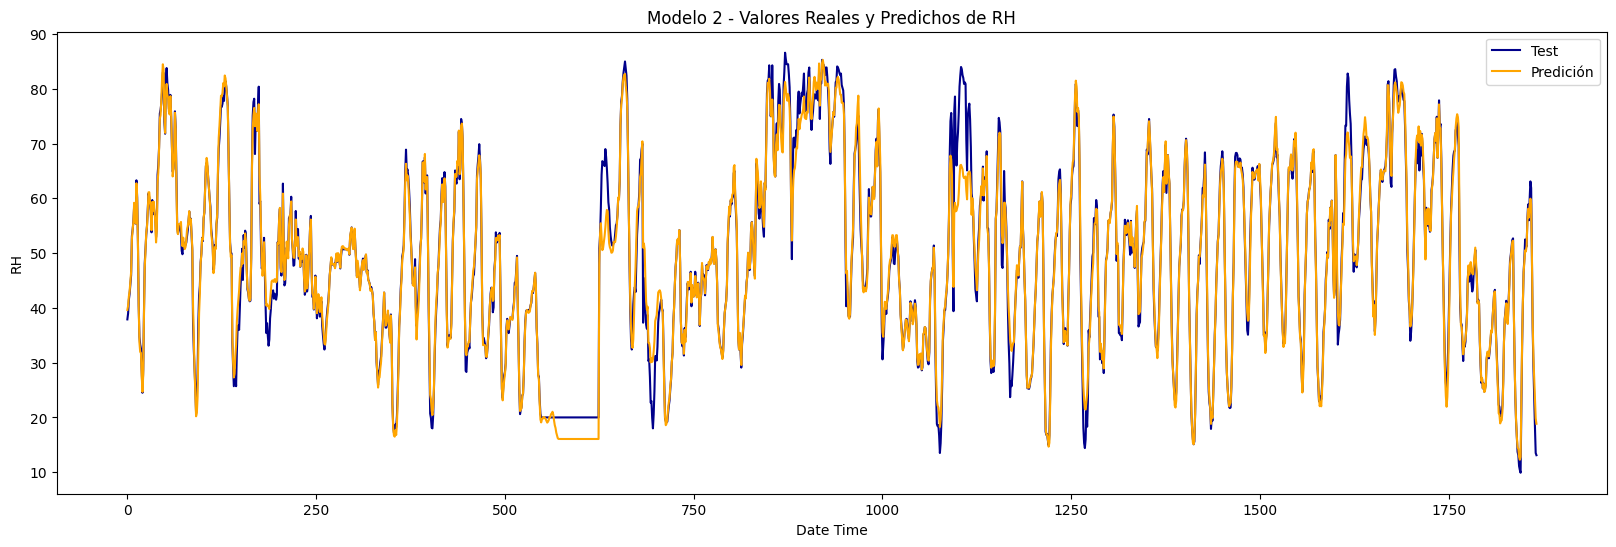

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(y_test, label='Test', color='darkblue')
plt.plot(y_pred, label='Predición', color='orange')
plt.xlabel('Date Time')
plt.ylabel('RH')
plt.title('Modelo 2 - Valores Reales y Predichos de RH')
plt.legend()
plt.show()

In [16]:
#Probamos otro valor de C

model3 = SVR(kernel='rbf', C=10, gamma=0.01)
model3.fit(X_train_scaled, y_train)

SVR(C=10, gamma=0.01)

In [17]:
y_pred = model3.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print('MAE:', mae)
print('MSE:', mse)

MAE: 0.31526210452044756
MSE: 0.3119826332801366


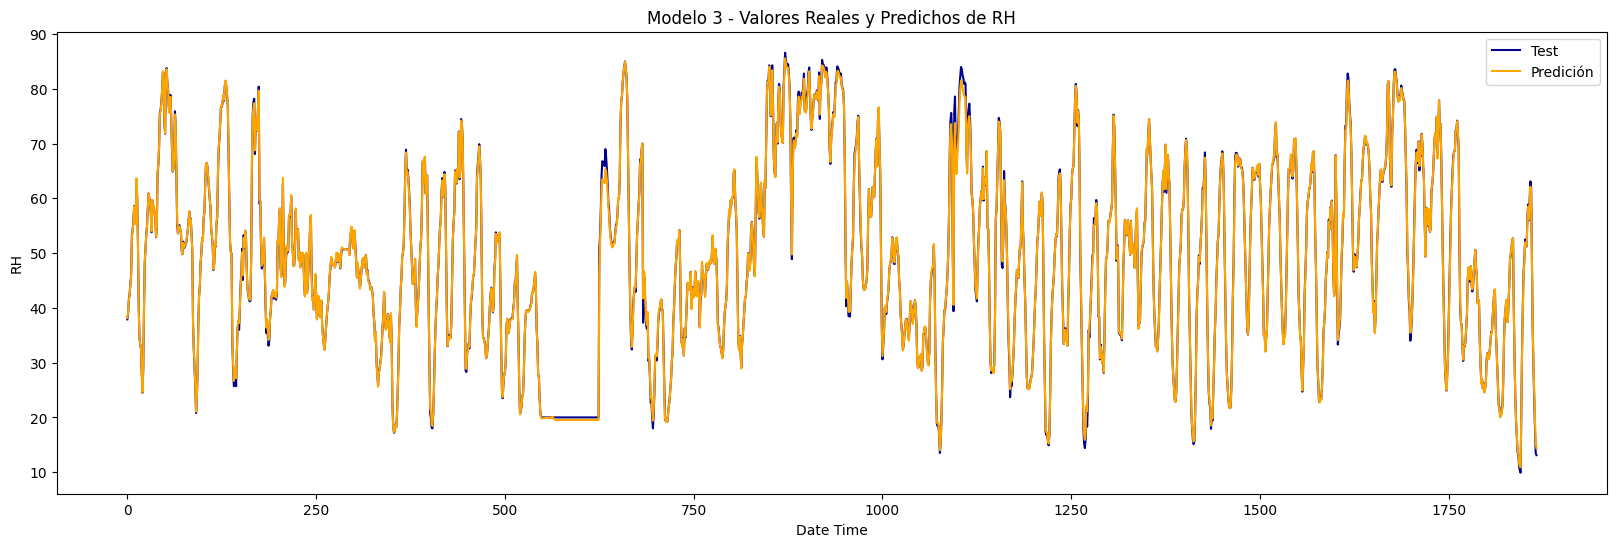

In [18]:
plt.figure(figsize=(20, 6))
plt.plot(y_test, label='Test', color='darkblue')
plt.plot(y_pred, label='Predición', color='orange')
plt.xlabel('Date Time')
plt.ylabel('RH')
plt.title('Modelo 3 - Valores Reales y Predichos de RH')
plt.legend()
plt.show()

In [ ]:
#Probamos otro valor de C

model4 = SVR(kernel='rbf', C=1, gamma=0.01)
model4.fit(X_train_scaled, y_train)

SVR(C=1, gamma=0.01)

In [ ]:
y_pred = model4.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print('MAE:', mae)
print('MSE:', mse)

MAE: 1.3758544222824935
MSE: 4.209274854758753


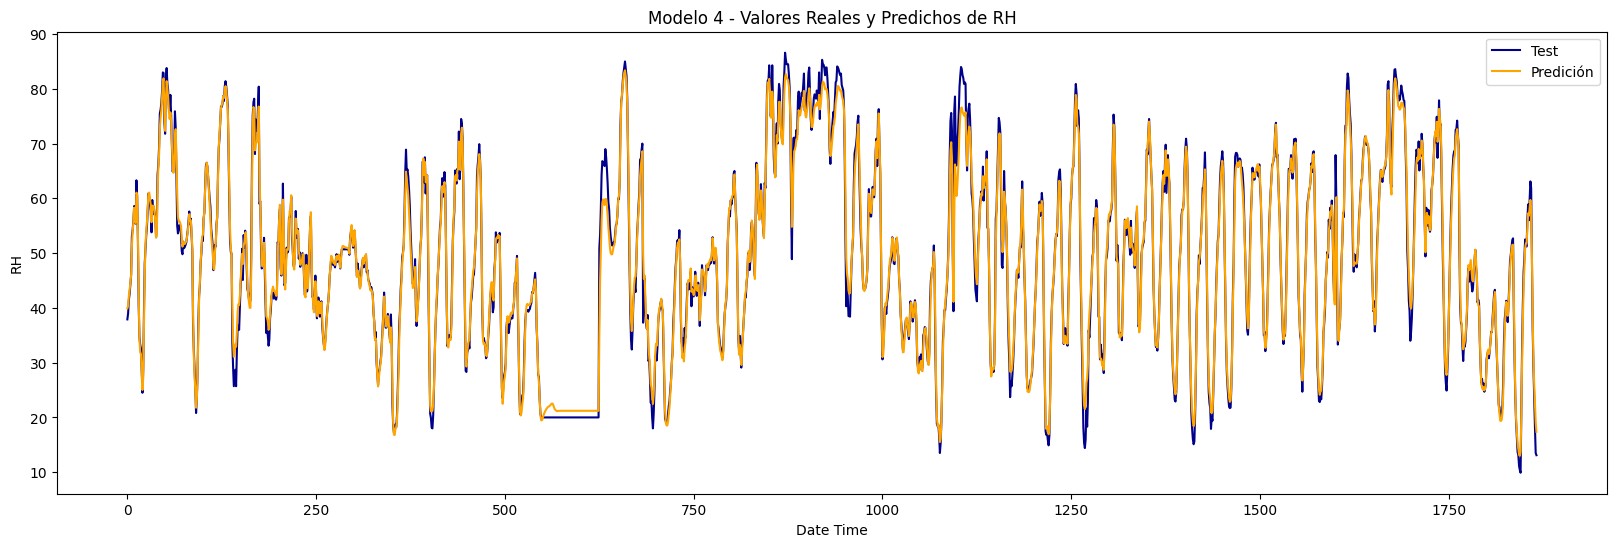

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(y_test, label='Test', color='darkblue')
plt.plot(y_pred, label='Predición', color='orange')
plt.xlabel('Date Time')
plt.ylabel('RH')
plt.title('Modelo 4 - Valores Reales y Predichos de RH')
plt.legend()
plt.show()

In [ ]:
# Modelo 5 con gamma = 'auto'

model5 = SVR(kernel='rbf', C=1, gamma='auto')
model5.fit(X_train_scaled, y_train)

SVR(C=1, gamma='auto')

In [ ]:
y_pred = model5.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print('MAE:', mae)
print('MSE:', mse)

MAE: 1.4464713889868586
MSE: 5.187106978660838


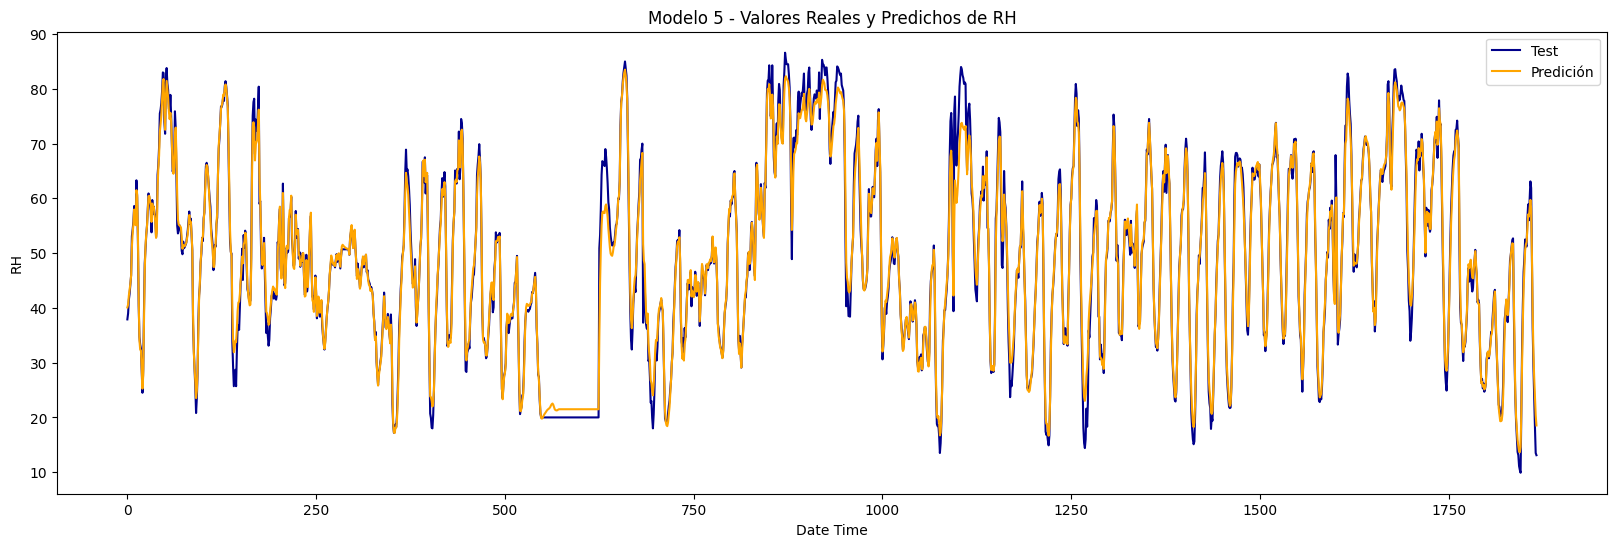

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(y_test, label='Test', color='darkblue')
plt.plot(y_pred, label='Predición', color='orange')
plt.xlabel('Date Time')
plt.ylabel('RH')
plt.title('Modelo 5 - Valores Reales y Predichos de RH')
plt.legend()
plt.show()

**Gráfico de la prediccion completa, train y test**

In [ ]:
# Predicción para las próximas 24 horas
future_predictions = []
current_points = df.iloc[-(lags + 1):]  # Usar los últimos 'lags + 1' puntos conocidos

for _ in range(24):
    # Crear características lagged y estacionales para los últimos puntos conocidos
    lagged_features = create_lagged_features(current_points, lags, seasonal_period)

    # Eliminar la columna 'target' para obtener solo las características (X)
    X_future = lagged_features.drop(columns=['target']).values

    # Si X_future está vacío, lanzar una advertencia
    if X_future.shape[0] == 0:
        print("Las características futuras están vacías.")
        break

    # Escala las características
    X_future_scaled = scaler.transform(X_future)

    # Realiza la predicción
    next_pred = model3.predict(X_future_scaled)[0]

    # Añadir la predicción actual a la lista de predicciones futuras
    future_predictions.append(next_pred)

    # Añadir la predicción actual a los puntos actuales para la siguiente iteración
    next_point = current_points.iloc[-1:].copy()
    next_point['target'] = next_pred
    current_points = pd.concat([current_points, next_point]).tail(lags + 1)

# Muestra las predicciones
print('Predicciones para las próximas 4 horas:', future_predictions)

Predicciones para las próximas 4 horas: [18.534289064460083, 17.863935656884756, 18.073910999438773, 19.25520048604509, 20.32212581380974, 21.783336362821146, 23.028468862440622, 24.084326654047178, 24.897978615813773, 25.528643859319892, 26.016191908321034, 26.607627227735158, 27.24923272790963, 27.818112650949782, 28.25693810342839, 28.667863869644997, 28.278254235405825, 26.829385717084723, 24.695612492088426, 23.767366960824866, 23.741810260149006, 23.976533967325885, 24.304927295451563, 24.566248341614656]


In [ ]:
# Predicción para la próxima hora
current_point = df.iloc[-lags:]  # Usar los últimos 'lags' puntos conocidos

# Crear características lagged y estacionales para el último punto conocido
lagged_features = create_lagged_features(current_point, lags, seasonal_period)

# Eliminar la columna 'target' para obtener solo las características (X)
X_future = lagged_features.drop(columns=['target']).values

# Si X_future está vacío, lanzar una advertencia
if X_future.shape[0] == 0:
    print("Las características futuras están vacías.")
else:
    # Escala las características
    X_future_scaled = scaler.transform(X_future)

    # Realiza la predicción
    next_pred = model5.predict(X_future_scaled)[0]

    print('Predicción para la próxima hora:', next_pred)

Las características futuras están vacías.


In [ ]:
# Predicción en los datos de entrenamiento
y_pred_train = model3.predict(X_train_scaled)

In [ ]:
y_pred_completo = np.concatenate((y_pred, y_pred_train))
y_completo = np.concatenate((y_train, y_test))

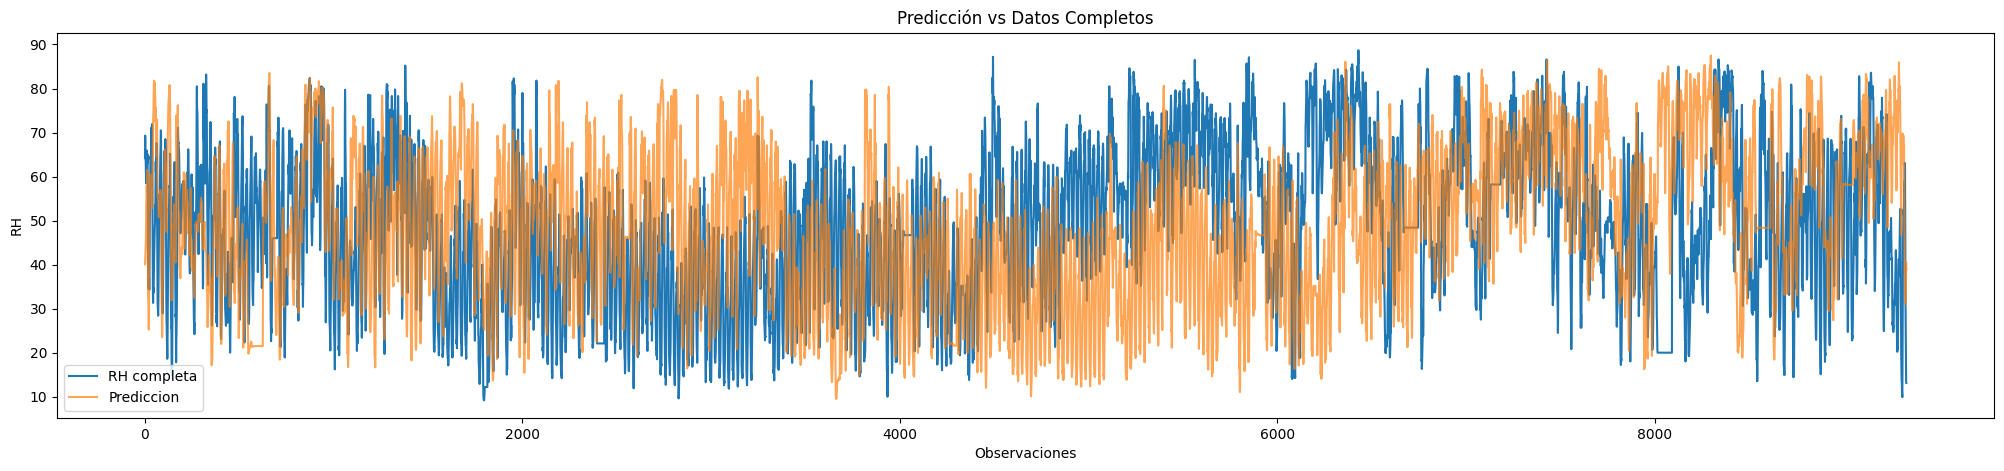

In [ ]:
fig, ax = plt.subplots(figsize=(25,5))

ax.plot(y_completo.flatten(),label="RH completa")
ax.plot(y_pred_completo,label="Prediccion", alpha=0.7)
ax.set_title("Predicción vs Datos Completos")
ax.set_xlabel("Observaciones")
ax.set_ylabel("RH")
plt.legend()
plt.show()


In [ ]:
#rmse sobre todo los valores predecidos
diferencia=np.square(y_completo-y_pred_completo)
proms=np.mean(diferencia)
rmse=np.sqrt(proms)
print(rmse)

23.043872844369556


**Prediccion para 24 horas**

In [ ]:
# Predicción para la próxima hora se usan los lags+1 puntos conocidos para asegurar suficientes datos para características
current_points = df.iloc[-(lags + 1):]

# Crear características lagged y estacionales para el último punto conocido
lagged_features = create_lagged_features(current_points, lags, seasonal_period)

# Eliminar la columna 'target' para obtener solo las características (X)
X_future = lagged_features.drop(columns=['target']).values

# Si X_future está vacío, lanzar una advertencia
if X_future.shape[0] == 0:
    print("Las características futuras están vacías.")
else:
    # Escala las características
    X_future_scaled = scaler.transform(X_future)

    # Realiza la predicción
    pred_1hora = model5.predict(X_future_scaled)[0]

    print('Predicción para la próxima hora:', pred_1hora)

Predicción para la próxima hora: 18.534289064460083


In [ ]:
# Predicción para las próximas 24 horas
future_predictions = []
current_points = df.iloc[-(lags + 1):]

for _ in range(24):

    lagged_features = create_lagged_features(current_points, lags, seasonal_period)

    # Eliminar la columna 'target' para obtener solo las características (X)
    X_future = lagged_features.drop(columns=['target']).values

    # Si X_future está vacío, lanzar una advertencia
    if X_future.shape[0] == 0:
        print("Las características futuras están vacías.")
        break

    X_future_scaled = scaler.transform(X_future)
    next_pred = model5.predict(X_future_scaled)[0]
    future_predictions.append(next_pred)

    # Añadir la predicción actual a los puntos actuales para la siguiente iteración
    next_point = current_points.iloc[-1:].copy()
    next_point['target'] = next_pred
    current_points = pd.concat([current_points, next_point]).tail(lags + 1)

print('Predicciones para las próximas 24 horas:', future_predictions)

Predicciones para las próximas 24 horas: [18.534289064460083, 17.863935656884756, 18.073910999438773, 19.25520048604509, 20.32212581380974, 21.783336362821146, 23.028468862440622, 24.084326654047178, 24.897978615813773, 25.528643859319892, 26.016191908321034, 26.607627227735158, 27.24923272790963, 27.818112650949782, 28.25693810342839, 28.667863869644997, 28.278254235405825, 26.829385717084723, 24.695612492088426, 23.767366960824866, 23.741810260149006, 23.976533967325885, 24.304927295451563, 24.566248341614656]


In [ ]:
# Crear un índice para las predicciones futuras
future_index = pd.date_range(start=df.index[-1] + pd.Timedelta(hours=1), periods=24, freq='H')
furute_index = future_index.strftime('%Y-%m-%d %H:%M:%S')
print(furute_index)

Index(['2005-04-04 15:00:00', '2005-04-04 16:00:00', '2005-04-04 17:00:00',
       '2005-04-04 18:00:00', '2005-04-04 19:00:00', '2005-04-04 20:00:00',
       '2005-04-04 21:00:00', '2005-04-04 22:00:00', '2005-04-04 23:00:00',
       '2005-04-05 00:00:00', '2005-04-05 01:00:00', '2005-04-05 02:00:00',
       '2005-04-05 03:00:00', '2005-04-05 04:00:00', '2005-04-05 05:00:00',
       '2005-04-05 06:00:00', '2005-04-05 07:00:00', '2005-04-05 08:00:00',
       '2005-04-05 09:00:00', '2005-04-05 10:00:00', '2005-04-05 11:00:00',
       '2005-04-05 12:00:00', '2005-04-05 13:00:00', '2005-04-05 14:00:00'],
      dtype='object')


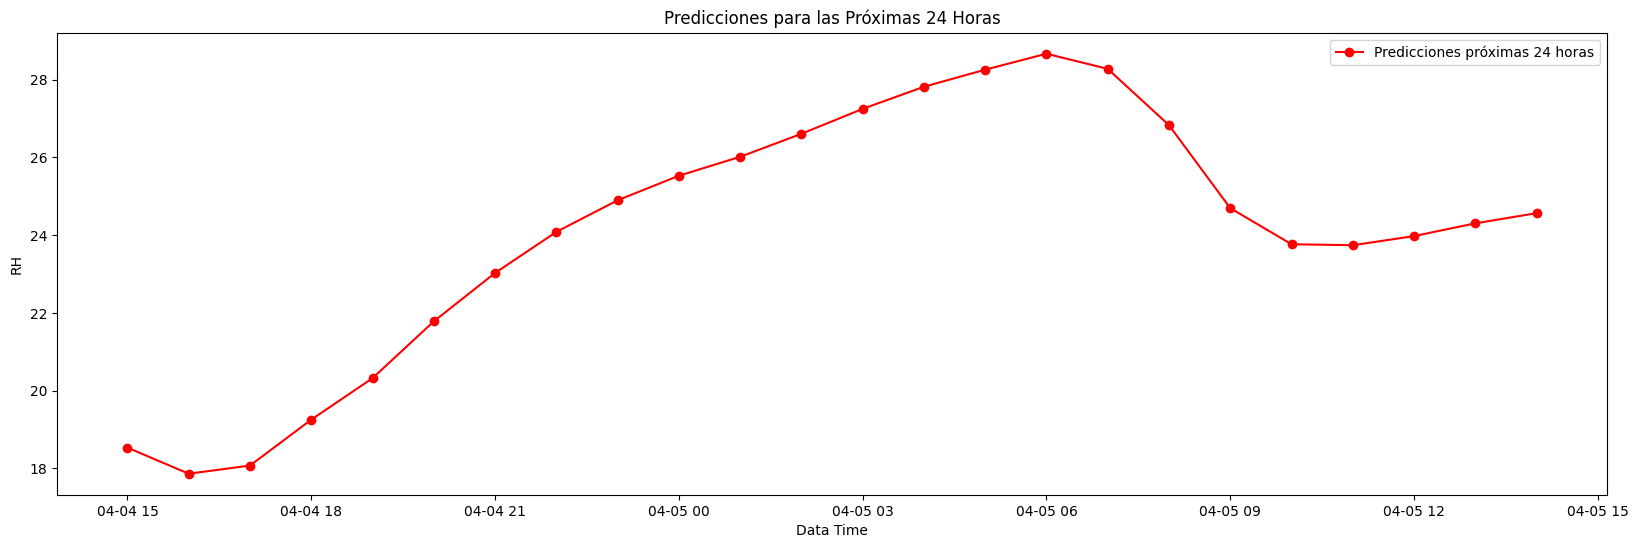

In [ ]:
# Grafica las predicciones futuras junto con los datos actuales
plt.figure(figsize=(20, 6))

# Predicciones futuras
plt.plot(future_index, future_predictions, label='Predicciones próximas 24 horas', color='red', marker='o')

plt.xlabel('Data Time')
plt.ylabel('RH')
plt.title('Predicciones para las Próximas 24 Horas')
plt.legend()
plt.show()

In [ ]:
# Filtrar las últimas 100 observaciones de la columna 'RH' con los indices
ultimos_100_datos = df['RH'].tail(100)
print(ultimos_100_datos)

Datetime
2005-03-31 11:00:00    36.9
2005-03-31 12:00:00    33.0
2005-03-31 13:00:00    30.3
2005-03-31 14:00:00    33.2
2005-03-31 15:00:00    32.9
                       ... 
2005-04-04 10:00:00    29.3
2005-04-04 11:00:00    23.7
2005-04-04 12:00:00    18.3
2005-04-04 13:00:00    13.5
2005-04-04 14:00:00    13.1
Name: RH, Length: 100, dtype: float64


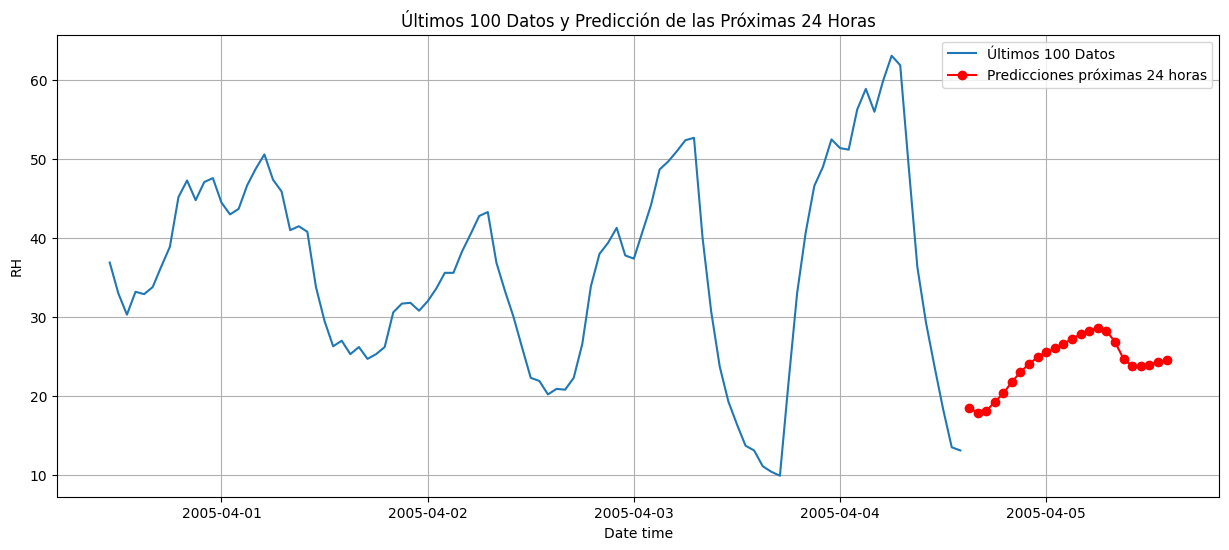

In [ ]:
# Graficar los últimos 100 datos y las predicciones futuras
plt.figure(figsize=(15, 6))

# Graficar los últimos 100 datos
plt.plot(ultimos_100_datos.index, ultimos_100_datos, label='Últimos 100 Datos')

# Graficar las predicciones futuras
plt.plot(future_index, future_predictions, label='Predicciones próximas 24 horas', color='red', marker='o')

# Configurar el gráfico
plt.xlabel('Date time')
plt.ylabel('RH')
plt.title('Últimos 100 Datos y Predicción de las Próximas 24 Horas')
plt.legend()
plt.grid(True)
plt.show()